In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad

In [74]:
sc._settings.ScanpyConfig.n_jobs = 8

In [75]:
def z_score_normalization(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

def reorder_columns(df, col_changed, col_position) -> pd.DataFrame:
    """
    Reordering colums. The second input can either be an integer for index or it can be a reference column name. If reference column name is chosen, the column will be placed after the reference column.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The first argument must be a pandas DataFrame")
    if not isinstance(col_changed, str):
        raise ValueError("The second argument must be a string representing a column name")
    if not isinstance(col_position, (str, int)):
        raise ValueError("The third argument must be either a string representing a column name or an integer representing a column index")
    if isinstance(col_position, int):
        cols = df.columns.tolist()
        if col_changed in cols and col_position <= len(cols) + 1:
            cols.remove(col_changed)
        
            index = col_position
            cols.insert(index, col_changed)
            
            df = df[cols]
    else:
        cols = df.columns.tolist()
        if col_changed in cols and col_position in cols:
            cols.remove(col_changed)
            index = cols.index(col_position)
            cols.insert(index+1, col_changed)
            
            df = df[cols]
    return df

In [76]:
df = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cycif_ovca/quantification/cycif_single_cell_spatial_25.csv', index_col=0)

In [77]:
df.head()

,ID,pERK,FOXP3,LaminB1,pSTAT1,IBA1,MHCII,CD57,CD8a,SMA,...,Ecadherin,FOXOA3,KRAS,X.Position,Y.Position,GlobalCellType2,neighbordood_cluster2,Stage,Patient_code_final,Sample_code_final
1,20284,0.372753,0.337156,0.367110,0.405686,0.408141,0.486107,0.385586,0.366450,0.292237,...,0.356802,0.364615,0.398076,2387,6443,IBA1.CD163.Macrophages,Epithelial_EMT,primary,S013,S013_primary
2,43273,0.401036,0.509924,0.512477,0.480357,0.512132,0.634644,0.512915,0.511404,0.505456,...,0.512238,0.512377,0.511586,3426,7956,Proliferating.epithelial,epithelial_and_proliferating_epithelial,primary,S013,S013_primary
3,562,0.361901,0.503882,0.504551,0.437978,0.505056,0.396402,0.505478,0.504477,0.505909,...,0.504303,0.505878,0.504723,1133,5112,Fibroblast,tumor-stroma-interface,primary,S013,S013_primary
4,29026,0.368904,0.536897,0.545607,0.423388,0.542831,0.629951,0.544818,0.538702,0.528172,...,0.543347,0.544746,0.539554,2746,7921,Proliferating.EMT,Proliferating.epithelial,primary,S013,S013_primary
5,67527,0.388265,0.501220,0.502478,0.415093,0.502006,0.516949,0.502401,0.501875,0.416413,...,0.501650,0.501756,0.500740,4891,2644,Proliferating.EMT,Proliferating.EMT,primary,S013,S013_primary


In [78]:
df.columns

Index(['ID', 'pERK', 'FOXP3', 'LaminB1', 'pSTAT1', 'IBA1', 'MHCII', 'CD57',
       'CD8a', 'SMA', 'CD11c', 'yH2AX', 'TAZ', 'Desmin', 'oldCD11b', 'CD31',
       'Ki67', 'TIM3', 'CD4', 'CD20', 'CK7', 'CD45RO', 'MHCI', 'CD3d', 'CD163',
       'CD207', 'HE4', 'Vimentin', 'SNAT1', 'Annexin', 'Ecadherin', 'FOXOA3',
       'KRAS', 'X.Position', 'Y.Position', 'GlobalCellType2',
       'neighbordood_cluster2', 'Stage', 'Patient_code_final',
       'Sample_code_final'],
      dtype='object')

In [79]:
len(df.Patient_code_final.unique())

16

In [80]:
len(df.Sample_code_final.unique())

22

In [81]:
df.Sample_code_final.unique()

array(['S013_primary', 'S002_primary', 'S009_primary', 'S007_primary',
       'S004_primary', 'S006_primary', 'S008_interval', 'S005_primary',
       'S001_interval', 'S016_primary', 'S008_primary', 'S011_interval',
       'S011_primary', 'S012_interval', 'S015_interval', 'S014_interval',
       'S015_primary', 'S014_primary', 'S012_primary', 'S003_primary',
       'S009_interval', 'S010_primary'], dtype=object)

In [82]:
df.GlobalCellType2.value_counts()

GlobalCellType2
Epithelial                  891733
EMT                         770551
Desmin.positive.cell        610795
Proliferating.epithelial    591620
IBA1.CD163.Macrophages      521663
SMA.CD31.positive.cell      485726
Proliferating.EMT           439766
Fibroblast                  389435
CD11c.myeloid               291619
Myofibroblast               271554
IBA1.CD11c.Macrophages      254471
CD8.T.cells                 231437
SMA.Desmin.positive.cell    193234
CD4.T.cells                 172207
Endothelial.cell            112278
CD163.Macrophages            93525
FOXP3.CD4.Tregs              87177
Bcell                         8611
Other                         5140
Name: count, dtype: int64

In [83]:
df.drop(columns=['neighbordood_cluster2', 'Stage', ], inplace=True) 
# x/y position are swapped in the original data
df.rename(columns={'GlobalCellType2': 'cell_type', 'X.Position': 'y', 'Y.Position': 'x', 'ID': 'cell_id', 'Sample_code_final': 'sample_id'}, inplace=True)

In [84]:
df = reorder_columns(df, 'cell_type', 'sample_id')

In [85]:
df = reorder_columns(df, 'cell_id', 'y')

In [86]:
df

,pERK,FOXP3,LaminB1,pSTAT1,IBA1,MHCII,CD57,CD8a,SMA,CD11c,...,Annexin,Ecadherin,FOXOA3,KRAS,y,cell_id,x,Patient_code_final,sample_id,cell_type
1,0.372753,0.337156,0.367110,0.405686,0.408141,0.486107,0.385586,0.366450,0.292237,0.363262,...,0.400954,0.356802,0.364615,0.398076,2387,20284,6443,S013,S013_primary,IBA1.CD163.Macrophages
2,0.401036,0.509924,0.512477,0.480357,0.512132,0.634644,0.512915,0.511404,0.505456,0.508607,...,0.409148,0.512238,0.512377,0.511586,3426,43273,7956,S013,S013_primary,Proliferating.epithelial
3,0.361901,0.503882,0.504551,0.437978,0.505056,0.396402,0.505478,0.504477,0.505909,0.503802,...,0.442016,0.504303,0.505878,0.504723,1133,562,5112,S013,S013_primary,Fibroblast
4,0.368904,0.536897,0.545607,0.423388,0.542831,0.629951,0.544818,0.538702,0.528172,0.536701,...,0.375871,0.543347,0.544746,0.539554,2746,29026,7921,S013,S013_primary,Proliferating.EMT
5,0.388265,0.501220,0.502478,0.415093,0.502006,0.516949,0.502401,0.501875,0.416413,0.500364,...,0.364061,0.501650,0.501756,0.500740,4891,67527,2644,S013,S013_primary,Proliferating.EMT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6422538,0.461307,0.000763,0.001621,0.518292,0.001122,0.228771,0.000895,0.001016,0.000809,0.001237,...,0.528250,0.001104,0.001428,0.001950,4097,36244,7476,S010,S010_primary,Epithelial
6422539,0.377578,0.000539,0.001472,0.436890,0.000676,0.203623,0.000662,0.000909,0.001035,0.001010,...,0.506569,0.001216,0.001379,0.001910,5185,44801,7323,S010,S010_primary,Epithelial
6422540,0.485293,0.000816,0.001623,0.530833,0.001099,0.223898,0.001038,0.001117,0.001232,0.001130,...,0.565752,0.001024,0.001482,0.002103,2624,17102,7092,S010,S010_primary,Proliferating.epithelial
6422541,0.434089,0.000658,0.001377,0.477240,0.001061,0.209598,0.000784,0.001857,0.001966,0.001138,...,0.673068,0.000535,0.001446,0.001910,4855,42468,5271,S010,S010_primary,CD8.T.cells


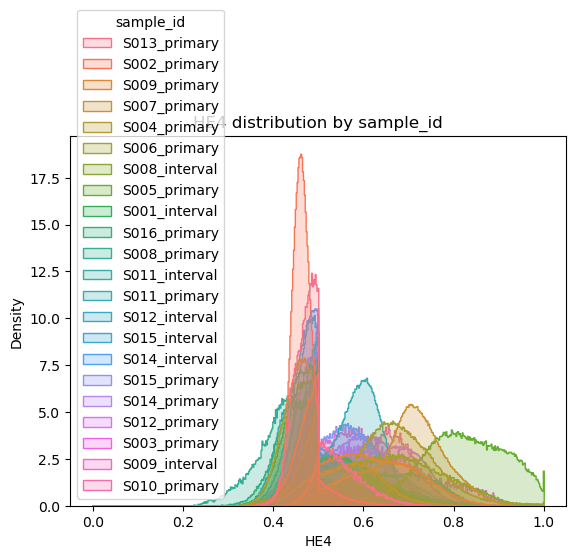

In [87]:
marker = 'HE4'
sns.histplot(data=df, x=marker, bins=500, hue='sample_id', element='step', stat='density', common_norm=False)
plt.xlabel(marker)
plt.ylabel('Density')
#plt.xlim(0, 0.02)
plt.title(f'{marker} distribution by sample_id')
plt.show()

Text(0.5, 1.0, 'CD3d median by sample_id')

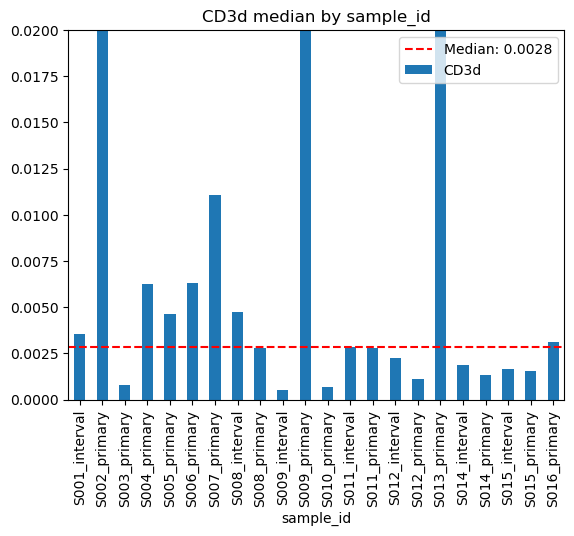

In [88]:
cd3d_median = df.groupby('sample_id')['CD3d'].median().median()
df.groupby('sample_id')['CD3d'].median().plot(kind='bar', ylim=[0, 0.02])
plt.axhline(cd3d_median, color='red', linestyle='--', label=f'Median: {cd3d_median:.4f}')
plt.legend()
plt.title('CD3d median by sample_id')

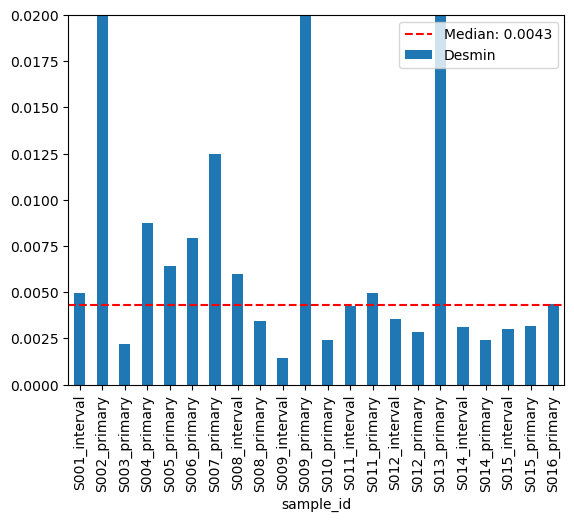

In [89]:
desmin_median = df.groupby('sample_id')['Desmin'].median().median()
df.groupby('sample_id')['Desmin'].median().plot(kind='bar', ylim=[0, 0.02])
plt.axhline(desmin_median, color='red', linestyle='--', label=f'Median: {desmin_median:.4f}')
plt.legend()

In [90]:
remove_samples = ['S002_primary', 'S003_primary', 'S004_primary', 'S007_primary', 'S009_interval', 'S009_primary', 'S013_primary', 'S006_primary', 'S005_primary', 'S008_interval', 'S15_interval', 'S14_interval', 'S12_interval', 'S11_interval', 'S10_interval', 'S01_primary', 'S02_primary', 'S03_primary', 'S04_primary', 'S05_primary', 'S06_primary', 'S07_primary', 'S08_interval', 'S09_interval', 'S10_interval', 'S11_interval', 'S12_interval', 'S13_primary']
df = df[~df['sample_id'].isin(remove_samples)]

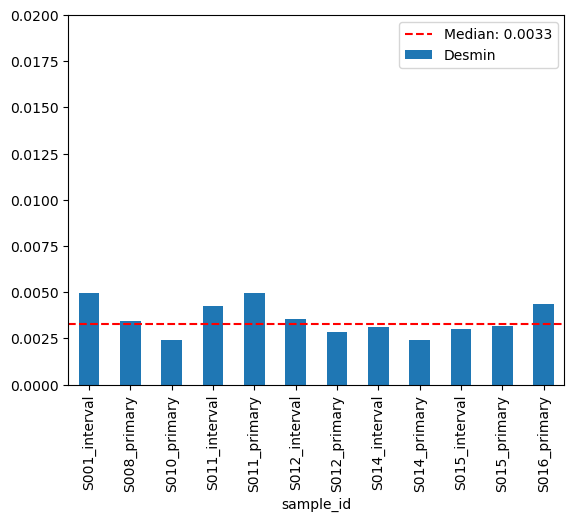

In [91]:
desmin_median = df.groupby('sample_id')['Desmin'].median().median()
df.groupby('sample_id')['Desmin'].median().plot(kind='bar', ylim=[0, 0.02])
plt.axhline(desmin_median, color='red', linestyle='--', label=f'Median: {desmin_median:.4f}')
plt.legend()

In [92]:
X_columns = df.columns[:df.columns.get_loc('x')]
obs_columns =df.columns[df.columns.get_loc('x'):]
adata = ad.AnnData(
    X=df[X_columns],
    obs=df[obs_columns],
    var=pd.DataFrame(index=X_columns)
)

/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/anndata/utils.py:311: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [93]:

adata.raw = adata.copy()
#adata.X = np.log1p(adata.X)
adata.layers['zscore'] = z_score_normalization(adata.X)
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')


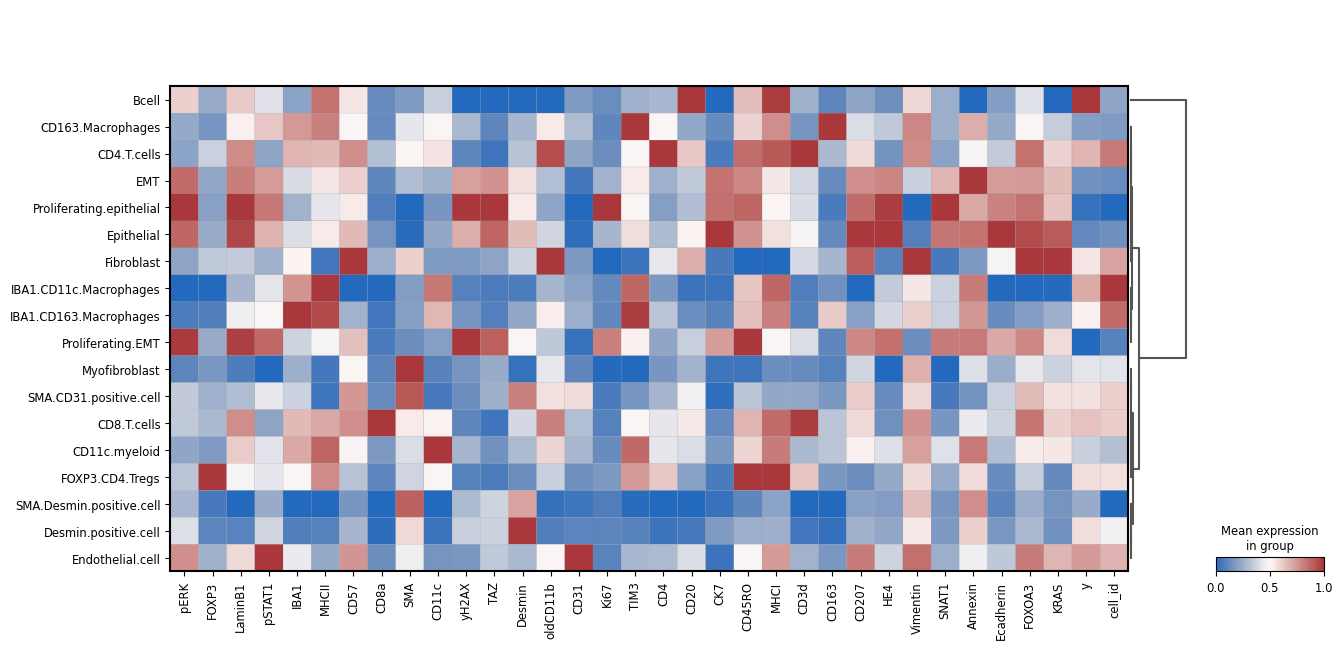

In [94]:
sc.tl.dendrogram(adata, groupby='cell_type')
sc.pl.matrixplot(adata, var_names=adata.var_names, groupby='cell_type', cmap='vlag', dendrogram=True, use_raw=False, standard_scale='var'
                 )

Cancer and emt do not really differ in thei expression profile. Also visually unclear what distinguishes them

# Harmonize celltype labels

In [95]:
df.columns

Index(['pERK', 'FOXP3', 'LaminB1', 'pSTAT1', 'IBA1', 'MHCII', 'CD57', 'CD8a',
       'SMA', 'CD11c', 'yH2AX', 'TAZ', 'Desmin', 'oldCD11b', 'CD31', 'Ki67',
       'TIM3', 'CD4', 'CD20', 'CK7', 'CD45RO', 'MHCI', 'CD3d', 'CD163',
       'CD207', 'HE4', 'Vimentin', 'SNAT1', 'Annexin', 'Ecadherin', 'FOXOA3',
       'KRAS', 'y', 'cell_id', 'x', 'Patient_code_final', 'sample_id',
       'cell_type'],
      dtype='object')

In [96]:
df['cell_type'].value_counts()

cell_type
Epithelial                  297422
Desmin.positive.cell        273302
IBA1.CD163.Macrophages      269075
EMT                         255671
SMA.CD31.positive.cell      237455
Fibroblast                  196050
Proliferating.epithelial    194090
CD8.T.cells                 157280
Myofibroblast               132229
CD11c.myeloid               130391
IBA1.CD11c.Macrophages      122606
Proliferating.EMT           110984
SMA.Desmin.positive.cell    108358
CD4.T.cells                  96678
Endothelial.cell             54607
FOXP3.CD4.Tregs              46486
CD163.Macrophages            44608
Bcell                         8419
Name: count, dtype: int64

In [97]:
df['cell_type'] = df['cell_type'].replace({'Epithelial': 'Cancer', 'Desmin.positive.cell': 'undefined', 'IBA1.CD163.Macrophages': 'M2_Macrophage', 'EMT': 'Cancer_EMT', 
                                           'SMA.CD31.positive.cell': 'EndoMT', 'Proliferating.epithelial': 'Cancer', 'CD8.T.cells': 'CD8+_T_cell', 'Myofibroblast': 'Myofibroblasts',
                                            'CD11c.myeloid': 'undefined', 'IBA1.CD11c.Macrophages': 'M1_Macrophage', 'Proliferating.EMT': 'Cancer_EMT', 
                                            'SMA.Desmin.positive.cell': 'undefined', 'CD4.T.cells': 'CD4+_T_cell', 'Endothelial.cell': 'Endothelial', 
                                            'FOXP3.CD4.Tregs': 'Treg', 'CD163.Macrophages': 'M2_Macrophage','Bcell': 'B_cell'})

df['cell_type'].value_counts()

/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_14067/676099045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cell_type'] = df['cell_type'].replace({'Epithelial': 'Cancer', 'Desmin.positive.cell': 'undefined', 'IBA1.CD163.Macrophages': 'M2_Macrophage', 'EMT': 'Cancer_EMT',


cell_type
undefined         512051
Cancer            491512
Cancer_EMT        366655
M2_Macrophage     313683
EndoMT            237455
Fibroblast        196050
CD8+_T_cell       157280
Myofibroblasts    132229
M1_Macrophage     122606
CD4+_T_cell        96678
Endothelial        54607
Treg               46486
B_cell              8419
Name: count, dtype: int64

In [98]:
df['cell_type'].nunique()

13

# Implement different levels of granularity

In [99]:
df['level_2_cell_type'] = df['cell_type']
df['level_2_cell_type'] = df['level_2_cell_type'].replace({'CD8+_T_cell':'Lymphoid_immune', 'M2_Macrophage':'Myeloid_immune', 'CD4+_T_cell':'Lymphoid_immune','Treg':'Lymphoid_immune', 'Dendritic_cell':'Myeloid_immune', 'B_cell':'Lymphoid_immune',
                                                           'Cancer_EMT':'Cancer', 'EndoMT':'Vascular', 'Myofibroblasts':'Fibroblast', 'M1_Macrophage':'Myeloid_immune', 'Dendritic_cell':'Myeloid_immune',
                                                           'Endothelial':'Vascular'})
df['level_2_cell_type'].value_counts()

/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_14067/2497237767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level_2_cell_type'] = df['cell_type']
/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_14067/2497237767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level_2_cell_type'] = df['level_2_cell_type'].replace({'CD8+_T_cell':'Lymphoid_immune', 'M2_Macrophage':'Myeloid_immune', 'CD4+_T_cell':'Lymphoid_immune','Treg':'Lymphoid_immune', 'Dendritic_cell':'Myeloid_immu

level_2_cell_type
Cancer             858167
undefined          512051
Myeloid_immune     436289
Fibroblast         328279
Lymphoid_immune    308863
Vascular           292062
Name: count, dtype: int64

In [100]:
df['level_1_cell_type'] = df['level_2_cell_type']
df['level_1_cell_type'] = df['level_1_cell_type'].replace({'Lymphoid_immune':'Immune', 'Myeloid_immune':'Immune', 'Fibroblast':'Stromal', 'Vascular':'Stromal'})
df['level_1_cell_type'].value_counts()

/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_14067/1748272094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level_1_cell_type'] = df['level_2_cell_type']
/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_14067/1748272094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level_1_cell_type'] = df['level_1_cell_type'].replace({'Lymphoid_immune':'Immune', 'Myeloid_immune':'Immune', 'Fibroblast':'Stromal', 'Vascular':'Stromal'})


level_1_cell_type
Cancer       858167
Immune       745152
Stromal      620341
undefined    512051
Name: count, dtype: int64

In [101]:
df = reorder_columns(df, 'cell_type', 'level_1_cell_type')
df = reorder_columns(df, 'level_2_cell_type', 'level_1_cell_type')
df 

,pERK,FOXP3,LaminB1,pSTAT1,IBA1,MHCII,CD57,CD8a,SMA,CD11c,...,FOXOA3,KRAS,y,cell_id,x,Patient_code_final,sample_id,level_1_cell_type,level_2_cell_type,cell_type
3601573,0.414528,0.003442,0.003773,0.386607,0.003929,0.229988,0.004146,0.004485,0.005015,0.003550,...,0.004316,0.005939,7685,214639,7593,S001,S001_interval,undefined,undefined,undefined
3601574,0.450408,0.003488,0.004890,0.485197,0.004068,0.497628,0.004093,0.004726,0.002965,0.004852,...,0.004706,0.006742,3603,109826,19057,S001,S001_interval,Cancer,Cancer,Cancer
3601575,0.441207,0.003207,0.003393,0.572271,0.003893,0.298974,0.003743,0.003939,0.004524,0.003430,...,0.004238,0.005402,17735,350734,20388,S001,S001_interval,undefined,undefined,undefined
3601576,0.403172,0.002878,0.003099,0.452826,0.003666,0.263917,0.003375,0.003959,0.004864,0.003136,...,0.003935,0.005326,19650,398055,12553,S001,S001_interval,undefined,undefined,undefined
3601577,0.403176,0.003243,0.003676,0.379703,0.004152,0.410285,0.003782,0.004688,0.005191,0.004406,...,0.004100,0.005747,932,6836,13522,S001,S001_interval,Stromal,Fibroblast,Myofibroblasts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6422538,0.461307,0.000763,0.001621,0.518292,0.001122,0.228771,0.000895,0.001016,0.000809,0.001237,...,0.001428,0.001950,4097,36244,7476,S010,S010_primary,Cancer,Cancer,Cancer
6422539,0.377578,0.000539,0.001472,0.436890,0.000676,0.203623,0.000662,0.000909,0.001035,0.001010,...,0.001379,0.001910,5185,44801,7323,S010,S010_primary,Cancer,Cancer,Cancer
6422540,0.485293,0.000816,0.001623,0.530833,0.001099,0.223898,0.001038,0.001117,0.001232,0.001130,...,0.001482,0.002103,2624,17102,7092,S010,S010_primary,Cancer,Cancer,Cancer
6422541,0.434089,0.000658,0.001377,0.477240,0.001061,0.209598,0.000784,0.001857,0.001966,0.001138,...,0.001446,0.001910,4855,42468,5271,S010,S010_primary,Immune,Lymphoid_immune,CD8+_T_cell


In [102]:
df['sample_id'] = df['sample_id'].str.replace('primary', 'chemonaive')
df['sample_id'] = df['sample_id'].str.replace('interval', 'IDS')
df

,pERK,FOXP3,LaminB1,pSTAT1,IBA1,MHCII,CD57,CD8a,SMA,CD11c,...,FOXOA3,KRAS,y,cell_id,x,Patient_code_final,sample_id,level_1_cell_type,level_2_cell_type,cell_type
3601573,0.414528,0.003442,0.003773,0.386607,0.003929,0.229988,0.004146,0.004485,0.005015,0.003550,...,0.004316,0.005939,7685,214639,7593,S001,S001_IDS,undefined,undefined,undefined
3601574,0.450408,0.003488,0.004890,0.485197,0.004068,0.497628,0.004093,0.004726,0.002965,0.004852,...,0.004706,0.006742,3603,109826,19057,S001,S001_IDS,Cancer,Cancer,Cancer
3601575,0.441207,0.003207,0.003393,0.572271,0.003893,0.298974,0.003743,0.003939,0.004524,0.003430,...,0.004238,0.005402,17735,350734,20388,S001,S001_IDS,undefined,undefined,undefined
3601576,0.403172,0.002878,0.003099,0.452826,0.003666,0.263917,0.003375,0.003959,0.004864,0.003136,...,0.003935,0.005326,19650,398055,12553,S001,S001_IDS,undefined,undefined,undefined
3601577,0.403176,0.003243,0.003676,0.379703,0.004152,0.410285,0.003782,0.004688,0.005191,0.004406,...,0.004100,0.005747,932,6836,13522,S001,S001_IDS,Stromal,Fibroblast,Myofibroblasts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6422538,0.461307,0.000763,0.001621,0.518292,0.001122,0.228771,0.000895,0.001016,0.000809,0.001237,...,0.001428,0.001950,4097,36244,7476,S010,S010_chemonaive,Cancer,Cancer,Cancer
6422539,0.377578,0.000539,0.001472,0.436890,0.000676,0.203623,0.000662,0.000909,0.001035,0.001010,...,0.001379,0.001910,5185,44801,7323,S010,S010_chemonaive,Cancer,Cancer,Cancer
6422540,0.485293,0.000816,0.001623,0.530833,0.001099,0.223898,0.001038,0.001117,0.001232,0.001130,...,0.001482,0.002103,2624,17102,7092,S010,S010_chemonaive,Cancer,Cancer,Cancer
6422541,0.434089,0.000658,0.001377,0.477240,0.001061,0.209598,0.000784,0.001857,0.001966,0.001138,...,0.001446,0.001910,4855,42468,5271,S010,S010_chemonaive,Immune,Lymphoid_immune,CD8+_T_cell


In [103]:
df['sample_id'].unique()

array(['S001_IDS', 'S016_chemonaive', 'S008_chemonaive', 'S011_IDS',
       'S011_chemonaive', 'S012_IDS', 'S015_IDS', 'S014_IDS',
       'S015_chemonaive', 'S014_chemonaive', 'S012_chemonaive',
       'S010_chemonaive'], dtype=object)

In [104]:
df['sample_id'].nunique()

12

In [105]:
df

,pERK,FOXP3,LaminB1,pSTAT1,IBA1,MHCII,CD57,CD8a,SMA,CD11c,...,FOXOA3,KRAS,y,cell_id,x,Patient_code_final,sample_id,level_1_cell_type,level_2_cell_type,cell_type
3601573,0.414528,0.003442,0.003773,0.386607,0.003929,0.229988,0.004146,0.004485,0.005015,0.003550,...,0.004316,0.005939,7685,214639,7593,S001,S001_IDS,undefined,undefined,undefined
3601574,0.450408,0.003488,0.004890,0.485197,0.004068,0.497628,0.004093,0.004726,0.002965,0.004852,...,0.004706,0.006742,3603,109826,19057,S001,S001_IDS,Cancer,Cancer,Cancer
3601575,0.441207,0.003207,0.003393,0.572271,0.003893,0.298974,0.003743,0.003939,0.004524,0.003430,...,0.004238,0.005402,17735,350734,20388,S001,S001_IDS,undefined,undefined,undefined
3601576,0.403172,0.002878,0.003099,0.452826,0.003666,0.263917,0.003375,0.003959,0.004864,0.003136,...,0.003935,0.005326,19650,398055,12553,S001,S001_IDS,undefined,undefined,undefined
3601577,0.403176,0.003243,0.003676,0.379703,0.004152,0.410285,0.003782,0.004688,0.005191,0.004406,...,0.004100,0.005747,932,6836,13522,S001,S001_IDS,Stromal,Fibroblast,Myofibroblasts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6422538,0.461307,0.000763,0.001621,0.518292,0.001122,0.228771,0.000895,0.001016,0.000809,0.001237,...,0.001428,0.001950,4097,36244,7476,S010,S010_chemonaive,Cancer,Cancer,Cancer
6422539,0.377578,0.000539,0.001472,0.436890,0.000676,0.203623,0.000662,0.000909,0.001035,0.001010,...,0.001379,0.001910,5185,44801,7323,S010,S010_chemonaive,Cancer,Cancer,Cancer
6422540,0.485293,0.000816,0.001623,0.530833,0.001099,0.223898,0.001038,0.001117,0.001232,0.001130,...,0.001482,0.002103,2624,17102,7092,S010,S010_chemonaive,Cancer,Cancer,Cancer
6422541,0.434089,0.000658,0.001377,0.477240,0.001061,0.209598,0.000784,0.001857,0.001966,0.001138,...,0.001446,0.001910,4855,42468,5271,S010,S010_chemonaive,Immune,Lymphoid_immune,CD8+_T_cell


In [106]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cycif_ovca/quantification/cycif_ovca_quantification.csv')

# Channel names after correspondence with lead author

In [107]:
channel_names=['DNA1', 'Rabbit', 'Goat', 'Mouse', 'DNA2', 'TAZ', 'CD207', 'SNAT1', 'DNA3', 'CD163', 'CD57', 'CD20', 'DNA4', 'Annexin', 'pSTAT1', 'KRAS', 'DNA5', 'CD4', 'pERK', 'CD8a', 'DNA6', 'CD45RO', 'FOXP3', 'CD3d', 'DNA7', 'TIM3', 'oldCD68', 'Desmin', 'DNA8', 'CD15','oldCD11b', 'FOXOA3', 'DNA9', 'HE4', 'CD11c', 'yH2AX', 'DNA10', 'Ki67', 'Vimentin', 'MHCII', 'DNA11', 'LaminB1', 'CK7', 'MHCI', 'DNA12', 'Ecadherin', 'SMA', 'CD31', 'DNA13', 'IBA1', 'CD68', 'CD11b']

In [108]:
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cycif_ovca/markers.txt', 'w') as f:
    for channel in channel_names:
        f.write(f"{channel}\n")